In [1]:
import collections

import sc2ts
import numpy as np
import tskit
import numpy as np
import tskit_arg_visualizer as argviz

import nb_utils

from IPython.display import HTML
HTML('<style type="text/css">.progress .progress-bar::after{content:"🦠";display:block;text-align:right;margin-top:-2px;}'
     '.progress .progress-bar {background-color: #BBBBFF}</style>')

assert np.__version__.startswith("2")

In [2]:
# Get the Viridian ARG
ts = nb_utils.load()
ti = sc2ts.TreeInfo(ts)
print(f"{ts.num_nodes} nodes, {ts.num_edges} edges, {ts.num_mutations} mutations, {np.sum(ts.nodes_flags & sc2ts.NODE_IS_RECOMBINANT != 0)} recombination events")

Loaded 731.5 megabyte SARS-CoV2 genealogy of 2482157 strains (345 trees, 1922947 mutations over 29904.0 basepairs). Last collection date is 2023-02-20


Counting descendants :   0%|          | 0/2689054 [00:00<?, ?it/s]

Indexing metadata    :   0%|          | 0/2689054 [00:00<?, ?it/s]

Classifying mutations:   0%|          | 0/1922947 [00:00<?, ?it/s]

2689054 nodes, 2689982 edges, 1922947 mutations, 929 recombination events


# HMM cost analysis

Using the `recombinant_reruns.json` file, check on all the recombination nodes: how close to the k=4 boundary are they (i.e. if they were not recombinants, how many mutations would they require, versus how many they currently require?). For this it it helpful to know the mutations required under no recombination (e.g. with k=1000) and allowing very permissive recombination (k=2)

In [3]:
import json
import collections
reruns = collections.defaultdict(dict)
with open("../data/recombinant_reruns.json") as f:
    for line in f:
        d = json.loads(line)
        assert d["num_mismatches"] not in reruns[d["strain"]]
        reruns[d["strain"]][d["num_mismatches"]] = d

In [4]:
def find_longest_near_consecutive_run(arr, allowed_distance=1):
    if len(arr) == 0:
        return 0, None
    
    # Sort the array
    sorted_arr = np.sort(arr)
    
    # Find where differences between adjacent elements is <= allowed_distance
    diffs = np.diff(sorted_arr)
    consecutive = (diffs <= allowed_distance)
    
    # Add a False at beginning and end to handle edge cases
    padded = np.pad(consecutive, (1, 1), 'constant', constant_values=False)
    
    # Find runs by detecting transitions
    run_starts = np.where(~padded[:-1] & padded[1:])[0]
    run_ends = np.where(padded[:-1] & ~padded[1:])[0]
    
    if len(run_starts) == 0:
        # No consecutive runs found
        return 1, sorted_arr[0]
    
    # Calculate run lengths
    run_lengths = run_ends - run_starts + 1
    
    # Find the longest run
    longest_idx = np.argmax(run_lengths)
    longest_length = run_lengths[longest_idx]
    start_idx = run_starts[longest_idx]
    start_value = sorted_arr[start_idx]
    
    return longest_length, start_value

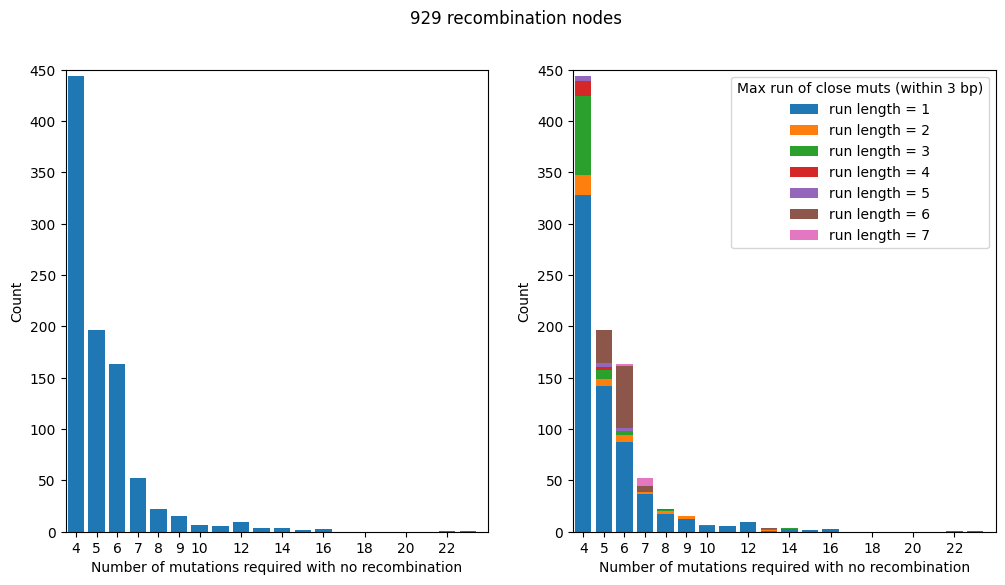

In [5]:
from matplotlib import pyplot as plt
import itertools

data = {}
sep = 3  # Allowed distance between "close" mutations to count as a single run
rl_data = collections.defaultdict(dict)
starts = collections.defaultdict(list)
for strain, v in reruns.items():
    if len(v) == 2:
        data[strain] = len(v[1000]["match"]["mutations"]) - len(v[2]["match"]["mutations"])
        # Find max contiguous run of mutations when recombination not allowed. This should be
        # basically the same as the max run length observed in the copying patterns
        positions = [m['site_position'] for m in v[1000]["match"]["mutations"]]
        max_consecutive, start = find_longest_near_consecutive_run(positions, sep)
        reruns[strain][f'runlength_{sep}sep'] = max_consecutive
        rl_data[max_consecutive][strain] = data[strain]
        starts[max_consecutive].append(start)

b = np.bincount(list(data.values()))
bottom = np.zeros(len(b))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
ax1.bar(np.arange(len(b)), b)
for runlen, d in sorted(rl_data.items()):
    bc = np.bincount(list(d.values()), minlength=len(b))
    ax2.bar(np.arange(len(bc)), bc, bottom=bottom, label=f"run length = {runlen}")
    bottom += bc
ax2.legend(title=f"Max run of close muts (within {sep} bp)")
plt.xlim(3.5, len(b))
plt.xticks(list(range(4, 10)) + list(range(10, len(b), 2)))
plt.suptitle(f"{sum(b)} recombination nodes")
for ax in (ax1, ax2):
    ax.set_ylim(0, 450)
    ax.set_xlabel("Number of mutations required with no recombination")
    ax.set_ylabel("Count")


In [6]:
# Add to the `recombinants.csv` file, if not already present
import pandas as pd
filename = "../data/recombinants.csv"
df = pd.read_csv(filename)
new_df = df.set_index("sample_id")
colnames = ["k2_num_mutations", "k1000_num_mutations", "num_mutations_averted", "max_runlength_3sep"]
new_df.loc[np.array(list(reruns.keys())), colnames[0]] = [len(r[2]['match']['mutations']) for r in reruns.values()]
new_df.loc[np.array(list(reruns.keys())), colnames[1]] = [len(r[1000]['match']['mutations']) for r in reruns.values()]
new_df.loc[np.array(list(reruns.keys())), colnames[3]] = [r['runlength_3sep'] for r in reruns.values()]
new_df[colnames[2]] = new_df.k1000_num_mutations - new_df.k2_num_mutations
new_df = new_df.astype({colname:'int' for colname in colnames})
new_df.reset_index(inplace=True)
print(f"Overwriting exising {filename} to add columns {colnames}")
for colname in colnames:
    df[colname] = new_df[colname]

df.to_csv(filename, index=False)

Overwriting exising ../data/recombinants.csv to add columns ['k2_num_mutations', 'k1000_num_mutations', 'num_mutations_averted', 'max_runlength_3sep']


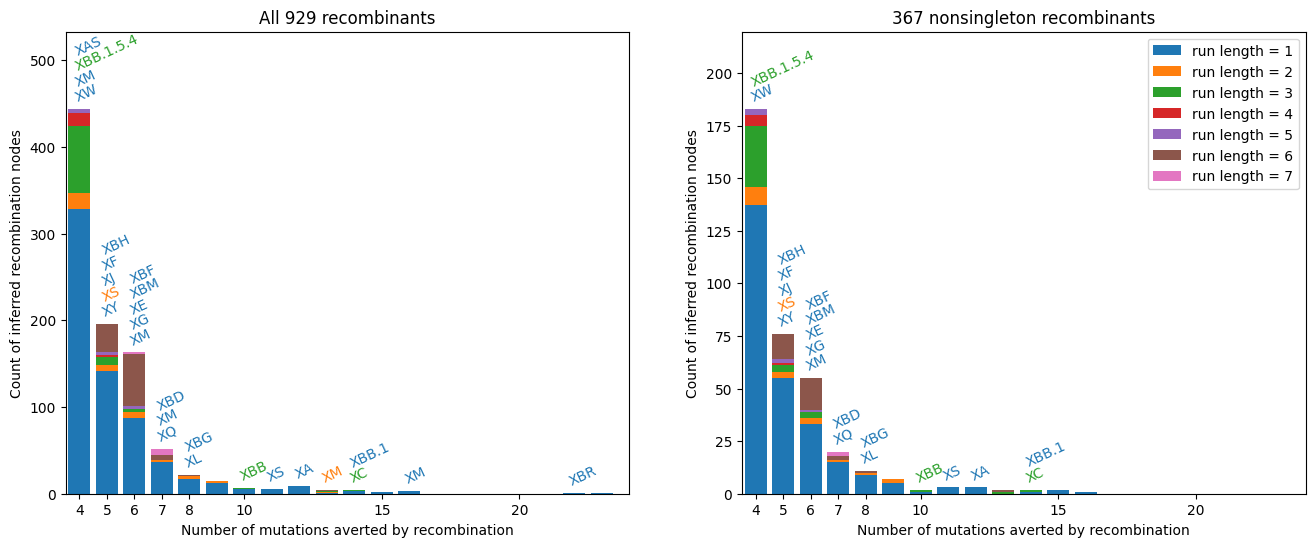

In [7]:
## Additional plots
import matplotlib.colors as mcolors

palette = ["#332288", "#88CCEE", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
palette = mcolors.TABLEAU_COLORS
colour = {i+1: c for i, c in enumerate(palette)}
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
for ax, df in zip(axes, (new_df, new_df[new_df.descendants != 1])):
    if len(df)==len(new_df):
        ax.set_title(f"All {len(df)} recombinants")
    else:
        ax.set_title(f"{len(df)} nonsingleton recombinants")
    tot_bc = np.bincount(df.num_mutations_averted)
    max_h = max(tot_bc)*1.2
    ax.set_ylim(0, max_h)
    bottom = np.zeros(len(tot_bc))
    labels = collections.defaultdict(set)
    for runlen in np.unique(df.max_runlength_3sep):
        sub_df = df[df.max_runlength_3sep==runlen]
        bc = np.bincount(sub_df.num_mutations_averted, minlength=len(tot_bc))
        ax.bar(np.arange(len(bc)), bc, bottom=bottom, label=f"run length = {runlen}", facecolor=colour[runlen])
        for g, rows in sub_df.groupby("num_mutations_averted"):
            for row in rows.itertuples():
                if row.sample_pango.startswith("X"):
                    assert row.max_runlength_3sep == runlen
                    labels[g].add((row.sample_pango, row.max_runlength_3sep))
        bottom += bc

    for g, label in labels.items():   
        if len(label):
            bar_top = tot_bc[g]+max(tot_bc)*0.02
            for i, line in enumerate(sorted(label, key=lambda x: (len(x), x), reverse=True)):
                ax.text(g - 0.25, bar_top + max_h * i / 30, line[0], rotation=25, c=colour[line[1]])
    ax.set_xlabel("Number of mutations averted by recombination")
    ax.set_ylabel("Count of inferred recombination nodes")
        
plt.xlim(3.5, np.max(new_df.num_mutations_averted) + 1)
plt.xticks(list(range(4, 9)) + [10, 15, 20])
handles, labels = ax.get_legend_handles_labels()
plt.legend();


## Plot the same data but in continuous space

Reweight the 

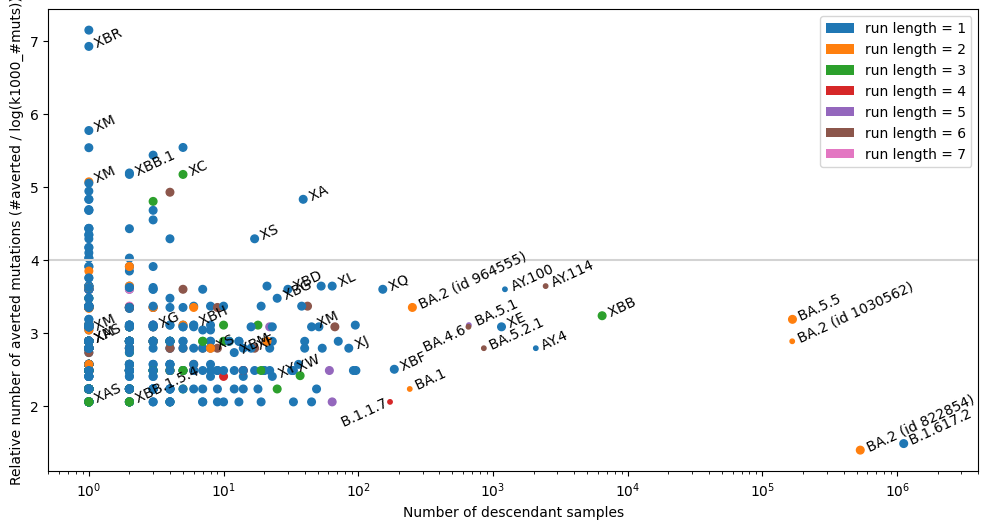

In [8]:
# (break down by number of descendants, and use a ratio)

identified_artifactual = [1030562, 293131, 295320, 293126, 1253364, 1279026, 1338895, 871356, 179752]

fig, axes = plt.subplots(figsize=(12, 6))
x = new_df.descendants
y = ((new_df.k1000_num_mutations-new_df.k2_num_mutations) / np.log(new_df.k1000_num_mutations))
plt.axhline(4, c="lightgrey")  # an arbitrary line: obove this recombinants probably OK.
plt.scatter(
    x, y,
    c=[colour[i] for i in new_df.max_runlength_3sep],
    s=np.where(np.isin(new_df.recombinant, identified_artifactual), 10, 30)
)
for row, x_p, y_p in zip(new_df.itertuples(), x, y):
    if row.sample_pango.startswith("X") or row.descendants > 1e2:
        label = f" {row.sample_pango}"
        ha="left"
        dy = -0.03
        if label.endswith("BA.2"):
            label += f" (id {row.recombinant})"
        elif label.endswith("BA.4.6") or label.endswith("B.1.1.7"):
            label += ""
            ha="right"
            dy=-0.35
        plt.text(x_p, y_p + dy, label, rotation=25, ha=ha)

plt.xscale("log")
plt.xlabel("Number of descendant samples")
plt.ylabel("Relative number of averted mutations (#averted / log(k1000_#muts))")
ticks = np.linspace(0, 1, 6)
plt.legend(handles, labels, loc='best') #, ncol=2, labelspacing = 0.2)
plt.xlim(0.5, 4e6);

## Extra analysis
Dig into where these large run lengths are coming from.  E.g. do they correspond to the Delta deletion @22029

In [9]:
for k in sorted(starts.keys()):
    if k != 1:
        print(
            f"Max contiguous muts={k}: ",
            {f"start@{int(k)}": v for k, v in sorted(collections.Counter(starts[k]).items(), key=lambda x: -x[1])})

Max contiguous muts=2:  {'start@27382': 15, 'start@22197': 8, 'start@28370': 4, 'start@29575': 1, 'start@1627': 1, 'start@8983': 1, 'start@21550': 1, 'start@23957': 1, 'start@26022': 1, 'start@22673': 1, 'start@25534': 1, 'start@25517': 1, 'start@24958': 1, 'start@27526': 1, 'start@25562': 1, 'start@3685': 1, 'start@27874': 1, 'start@27883': 1}
Max contiguous muts=3:  {'start@27881': 30, 'start@22195': 16, 'start@29757': 15, 'start@507': 9, 'start@26488': 5, 'start@28881': 4, 'start@5703': 2, 'start@27038': 2, 'start@26721': 2, 'start@28280': 2, 'start@27758': 1, 'start@3929': 1, 'start@22895': 1, 'start@27377': 1, 'start@28132': 1, 'start@28238': 1, 'start@28273': 1}
Max contiguous muts=4:  {'start@28241': 6, 'start@27572': 3, 'start@27880': 2, 'start@22031': 1, 'start@26485': 1, 'start@27879': 1, 'start@28238': 1, 'start@28255': 1, 'start@29571': 1}
Max contiguous muts=5:  {'start@22030': 7, 'start@27879': 3, 'start@686': 2}
Max contiguous muts=6:  {'start@22027': 93, 'start@686': 6,

In [10]:
# Check on one example of runlength 6
NodeReport = collections.namedtuple("NodeReport", nb_utils.NODE_REPORT_KEYS)


check_strain = list(rl_data[6].keys())[-2]
print(f"For strain {check_strain}",
      "with no recombination, mutations are at",
      [m['site_position'] for m in reruns[check_strain][1000]["match"]["mutations"]]
)
re_node = [a for a in ts.first().ancestors(ti.strain_map[check_strain]) if (ts.nodes_flags[a] & sc2ts.NODE_IS_RECOMBINANT) != 0][0]

NodeReport(*ti.node_report(re_node)).copying_pattern

For strain SRR20254697 with no recombination, mutations are at [15854, 22027, 22030, 22031, 22032, 22033, 22034]


pos,247,4510,22027,22029,22030,22031,22032,22033,22034,23159,24675,26777,27749,29108
ref,G,G,T,A,G,T,T,C,A,T,A,T,A,C
P0,A,T,G,A,A,A,G,T,G,T,A,T,C,C
C,G,G,G,A,A,A,G,T,G,G,C,C,A,A
P1,G,G,T,-,-,-,-,-,-,G,C,C,A,A
mut,A>G,T>G,,,,,,,,,,,,


In [11]:
# Show where the deletions occur
deletion_positions = [s.position for s in ts.sites() for m in s.mutations if m.derived_state == "-" or s.ancestral_state=="-"]
prev_k = None
for k, v in sorted(collections.Counter(deletion_positions).items()):
    if k - 1 != prev_k:
        print()
    print(f"@{int(k)}: {v} deletion mutations")
    prev_k = k


@6513: 473 deletion mutations
@6514: 466 deletion mutations
@6515: 517 deletion mutations

@11283: 110 deletion mutations
@11284: 110 deletion mutations
@11285: 110 deletion mutations
@11286: 60 deletion mutations
@11287: 60 deletion mutations
@11288: 69 deletion mutations
@11289: 70 deletion mutations
@11290: 70 deletion mutations
@11291: 42 deletion mutations
@11292: 97 deletion mutations
@11293: 97 deletion mutations
@11294: 97 deletion mutations
@11295: 27 deletion mutations
@11296: 27 deletion mutations

@21633: 33 deletion mutations
@21634: 15 deletion mutations
@21635: 19 deletion mutations
@21636: 13 deletion mutations
@21637: 13 deletion mutations
@21638: 13 deletion mutations
@21639: 13 deletion mutations
@21640: 12 deletion mutations
@21641: 12 deletion mutations

@21767: 662 deletion mutations
@21768: 680 deletion mutations
@21769: 703 deletion mutations
@21770: 696 deletion mutations

@21988: 383 deletion mutations
@21989: 376 deletion mutations
@21990: 519 deletion mutat

## Compare to what we would expect if mutations were neutral
Here we overlay roughly the same number of mutations onto the ARG in a neutral way

In [12]:
import numpy as np
import tskit

def extract_mutation_transition_model(ts):
    """
    Extract a row-normalized mutation transition matrix and root distribution
    from an msprime tree sequence.
    
    Parameters:
    -----------
    ts : tskit.TreeSequence
        The tree sequence from which to extract the mutation transitions
        
    Returns:
    --------
    numpy.ndarray
        A transition probability matrix where element [i,j] represents 
        the probability of transitioning from state i to state j.
        Each row sums to 1.0 (or 0 if no transitions from that state).
    numpy.ndarray
        The root (ancestral) distribution vector representing the 
        frequency of each state at the root of the genealogy.
    list
        The ordered list of alleles corresponding to matrix indices.
    """
    # Determine the number of distinct allelic states
    alleles = set()
    for site in ts.sites():
        for mutation in site.mutations:
            alleles.add(mutation.derived_state)
            # Add ancestral state as well
            alleles.add(site.ancestral_state)
    
    alleles = sorted(list(alleles))
    n_states = len(alleles)
    
    # Create mapping from allele to index
    allele_to_idx = {allele: idx for idx, allele in enumerate(alleles)}
    
    # Initialize transition matrix and root distribution
    count_matrix = np.zeros((n_states, n_states), dtype=float)
    root_counts = np.zeros(n_states, dtype=float)
    
    # Populate matrices
    for site in ts.sites():
        ancestral_idx = allele_to_idx[site.ancestral_state]
        root_counts[ancestral_idx] += 1
        
        # Process mutations at this site
        for mutation in site.mutations:
            derived_idx = allele_to_idx[mutation.derived_state]
            
            # If there's a parent mutation, use its state as the source
            if mutation.parent != -1:
                parent_mutation = ts.mutation(mutation.parent)
                source_idx = allele_to_idx[parent_mutation.derived_state]
            else:
                # Otherwise, use the ancestral state
                source_idx = ancestral_idx
            
            count_matrix[source_idx, derived_idx] += 1
    
    # Normalize rows to sum to 1
    row_sums = count_matrix.sum(axis=1)
    normalized_matrix = np.zeros_like(count_matrix)
    for i in range(n_states):
        if row_sums[i] > 0:
            normalized_matrix[i, :] = count_matrix[i, :] / row_sums[i]
    
    # Normalize root distribution
    total_sites = root_counts.sum()
    if total_sites > 0:
        root_distribution = root_counts / total_sites
    else:
        root_distribution = np.zeros_like(root_counts)
    
    return alleles, root_distribution, normalized_matrix


In [13]:
import msprime

mutational_area = np.sum((ts.edges_right-ts.edges_left) * (ts.nodes_time[ts.edges_parent] - ts.nodes_time[ts.edges_child]))
null_ts = msprime.sim_mutations(
    ts,
    rate=ts.num_mutations / mutational_area,
    model=msprime.MatrixMutationModel(*extract_mutation_transition_model(ts)),
    keep=False,
    random_seed=123,
)

In [14]:
# Count the number of site_pos+2state mutations
import collections
import tskit
muts = collections.Counter()
for site in ts.sites():
    for mut in site.mutations:
        inherited_state = site.ancestral_state if mut.parent == tskit.NULL else ts.mutation(mut.parent).derived_state
        muts[frozenset((site.position, mut.derived_state, inherited_state))] += 1

null_muts = collections.Counter()
for site in null_ts.sites():
    for mut in site.mutations:
        inherited_state = site.ancestral_state if mut.parent == tskit.NULL else null_ts.mutation(mut.parent).derived_state
        null_muts[frozenset((site.position, mut.derived_state, inherited_state))] += 1


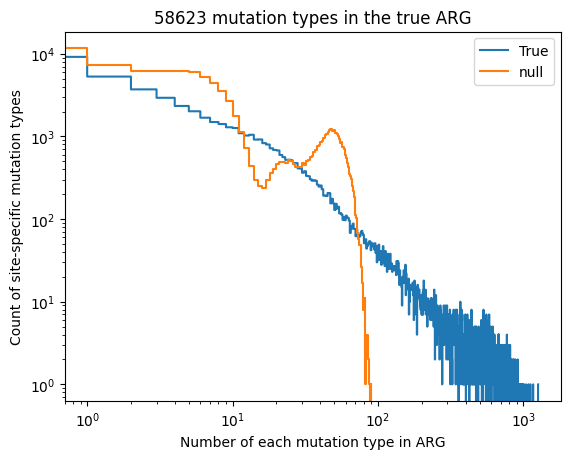

In [15]:
from matplotlib import pyplot as plt
bb = np.bincount(list(muts.values()))
plt.step(np.arange(len(bb)), bb, label="True")
null_bb = np.bincount(list(null_muts.values()))
plt.step(np.arange(len(null_bb)), null_bb, label="null")

plt.title(f"{sum(bb)} mutation types in the true ARG")
plt.xlabel("Number of each mutation type in ARG")
plt.ylabel("Count of site-specific mutation types")
plt.xscale("log")
plt.yscale("log")
plt.legend()